In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

arifkaggle979_violencetext_path = kagglehub.dataset_download('arifkaggle979/violencetext')
arifkaggle979_violence_modified_path = kagglehub.dataset_download('arifkaggle979/violence-modified')
arifkaggle979_modified_path = kagglehub.dataset_download('arifkaggle979/modified')
arifkaggle979_mofied2_path = kagglehub.dataset_download('arifkaggle979/mofied2')

print('Data source import complete.')


In [ ]:
pip install torch transformers pandas numpy sklearn tqdm


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Note: you may need to restart the kernel to use updated packages.


# Main code with BanglaBERT+Capsule Network

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import re
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import RandomOverSampler  # Import RandomOverSampler
import unicodedata

# Load BanglaBERT Tokenizer
tokenizer = AutoTokenizer.from_pretrained("csebuetnlp/banglabert")

# Load Dataset
def load_data(file_path):
    df = pd.read_csv(file_path)
    df = df[['text', 'label']]
    return df

train_df = load_data("/kaggle/input/violencetext/train.csv")
dev_df = load_data("/kaggle/input/violencetext/dev.csv")
test_df = load_data("/kaggle/input/violencetext/test.csv")

# **Step 1: Apply Random Oversampling to Balance the Datasets**
def oversample_dataset(df):
    ros = RandomOverSampler(random_state=42)
    texts, labels = df["text"].values, df["label"].values
    texts_resampled, labels_resampled = ros.fit_resample(texts.reshape(-1, 1), labels)

    balanced_df = pd.DataFrame({"text": texts_resampled.flatten(), "label": labels_resampled})
    return balanced_df

train_df = oversample_dataset(train_df)
dev_df = oversample_dataset(dev_df)
test_df = oversample_dataset(test_df)

# **Step 2: Preprocessing Function**
def preprocess_text(text):
    text = unicodedata.normalize('NFKC', text)  # Normalize Unicode text
    text = re.sub(r'[০-৯]', '[NUMBER]', text)  # Replace Bangla numbers
    text = re.sub(r'http\S+|www\S+', '[URL]', text)  # Replace URLs
    text = re.sub(r'[^\u0980-\u09FF\s]', '', text)  # Remove non-Bangla characters
    text = re.sub(r'\s+', ' ', text).strip()  # Normalize whitespace
    return text

train_df["text"] = train_df["text"].apply(preprocess_text)
dev_df["text"] = dev_df["text"].apply(preprocess_text)
test_df["text"] = test_df["text"].apply(preprocess_text)

# **Step 3: Define Dataset Class**
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=70):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

# Prepare datasets
train_dataset = TextDataset(train_df["text"].tolist(), train_df["label"].tolist(), tokenizer)
dev_dataset = TextDataset(dev_df["text"].tolist(), dev_df["label"].tolist(), tokenizer)
test_dataset = TextDataset(test_df["text"].tolist(), test_df["label"].tolist(), tokenizer)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# **Step 4: Capsule Network Layer**
class CapsuleLayer(nn.Module):
    def __init__(self, num_capsules, input_dim, output_dim, routing_iterations=3):
        super(CapsuleLayer, self).__init__()
        self.num_capsules = num_capsules
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.routing_iterations = routing_iterations
        self.weights = nn.Parameter(torch.randn(num_capsules, input_dim, output_dim))

    def forward(self, x):
        x = x.unsqueeze(1).expand(-1, self.num_capsules, -1, -1)
        u_hat = torch.matmul(x, self.weights)

        b_ij = torch.zeros(u_hat.shape[0], self.num_capsules, u_hat.shape[2]).to(x.device)

        for _ in range(self.routing_iterations):
            c_ij = torch.nn.functional.softmax(b_ij, dim=1)
            s_j = (c_ij.unsqueeze(-1) * u_hat).sum(dim=2)
            v_j = self.squash(s_j)
            b_ij = b_ij + (u_hat * v_j.unsqueeze(2)).sum(dim=-1)

        return v_j

    @staticmethod
    def squash(tensor):
        norm = (tensor ** 2).sum(dim=-1, keepdim=True)
        scale = norm / (1 + norm)
        return scale * tensor / torch.sqrt(norm + 1e-8)

# **Step 5: Define CAPTAIN Model**
class CAPTAINModel(nn.Module):
    def __init__(self, num_classes=3):
        super(CAPTAINModel, self).__init__()
        self.bert = AutoModel.from_pretrained("csebuetnlp/banglabert")
        self.capsule = CapsuleLayer(num_capsules=8, input_dim=768, output_dim=16)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(8 * 16, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.batch_norm = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(0.5)

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        caps_output = self.capsule(bert_output)
        flat_output = self.flatten(caps_output)
        x = self.batch_norm(torch.relu(self.fc1(flat_output)))
        x = self.dropout(x)
        logits = self.fc2(x)
        return torch.nn.functional.log_softmax(logits, dim=1)

# **Step 6: Training Setup**
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CAPTAINModel().to(device)

optimizer = optim.AdamW(model.parameters(), lr=3e-5, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)

# **Step 7: Training Loop**
epochs = 30
for epoch in range(epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
        input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)

        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    scheduler.step()
    print(f"Epoch {epoch+1} Loss: {total_loss:.4f}, Accuracy: {correct/total:.4f}")

# **Step 8: Model Evaluation**
model.eval()
predictions, true_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["label"].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        labels = labels.cpu().numpy()

        predictions.extend(preds)
        true_labels.extend(labels)

# **Print Classification Report with 4-digit Precision**
print("Classification Report:")
print(classification_report(true_labels, predictions, digits=4))


Epoch 1 Loss: 132.5950, Accuracy: 0.4826


Epoch 2 Loss: 61.7987, Accuracy: 0.8229


Epoch 3 Loss: 33.7290, Accuracy: 0.9174


Epoch 4 Loss: 17.8525, Accuracy: 0.9604


Epoch 5 Loss: 10.3786, Accuracy: 0.9810


Epoch 6 Loss: 7.0204, Accuracy: 0.9909


Epoch 7 Loss: 3.6833, Accuracy: 0.9964


Epoch 8 Loss: 3.4092, Accuracy: 0.9959


Epoch 9 Loss: 2.6059, Accuracy: 0.9976


Epoch 10 Loss: 2.0346, Accuracy: 0.9976


Epoch 11 Loss: 2.3397, Accuracy: 0.9964


Epoch 12 Loss: 1.3269, Accuracy: 0.9978


Epoch 13 Loss: 0.9236, Accuracy: 0.9993


Epoch 14 Loss: 1.2350, Accuracy: 0.9988


Epoch 15 Loss: 0.7469, Accuracy: 0.9998


Epoch 16 Loss: 0.7024, Accuracy: 0.9995


Epoch 17 Loss: 0.9423, Accuracy: 0.9990


Epoch 18 Loss: 0.8807, Accuracy: 0.9993


Epoch 19 Loss: 1.2477, Accuracy: 0.9986


Epoch 20 Loss: 1.1687, Accuracy: 0.9986


Epoch 21 Loss: 0.9292, Accuracy: 0.9990


Epoch 22 Loss: 0.6593, Accuracy: 0.9993


Epoch 23 Loss: 0.4534, Accuracy: 0.9998


Epoch 24 Loss: 0.4647, Accuracy: 0.9998


Epoch 25 Loss: 0.4674, Accuracy: 0.9995


Epoch 26 Loss: 0.3877, Accuracy: 0.9998


Epoch 27 Loss: 0.4240, Accuracy: 0.9998


Epoch 28 Loss: 0.3795, Accuracy: 0.9998


Epoch 29 Loss: 0.4767, Accuracy: 0.9998


Epoch 30 Loss: 0.4868, Accuracy: 0.9995
Classification Report:
              precision    recall  f1-score   support

           0     0.6995    0.8686    0.7749      1096
           1     0.8159    0.6186    0.7037      1096
           2     0.8212    0.8212    0.8212      1096

    accuracy                         0.7695      3288
   macro avg     0.7788    0.7695    0.7666      3288
weighted avg     0.7788    0.7695    0.7666      3288



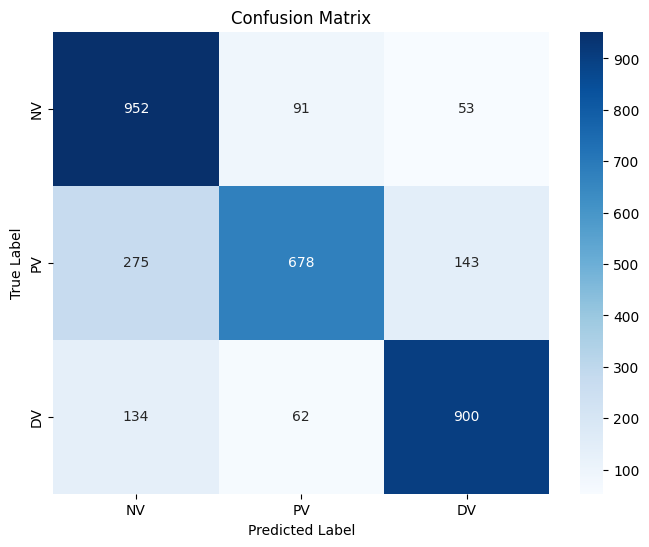

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# **Step 1: Compute Confusion Matrix**
cm = confusion_matrix(true_labels, predictions)

# **Step 2: Normalize Confusion Matrix (Optional, Uncomment to Enable)**
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize by row sum

# **Step 3: Plot Confusion Matrix**
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["NV", "PV", "DV"], yticklabels=["NV", "PV", "DV"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


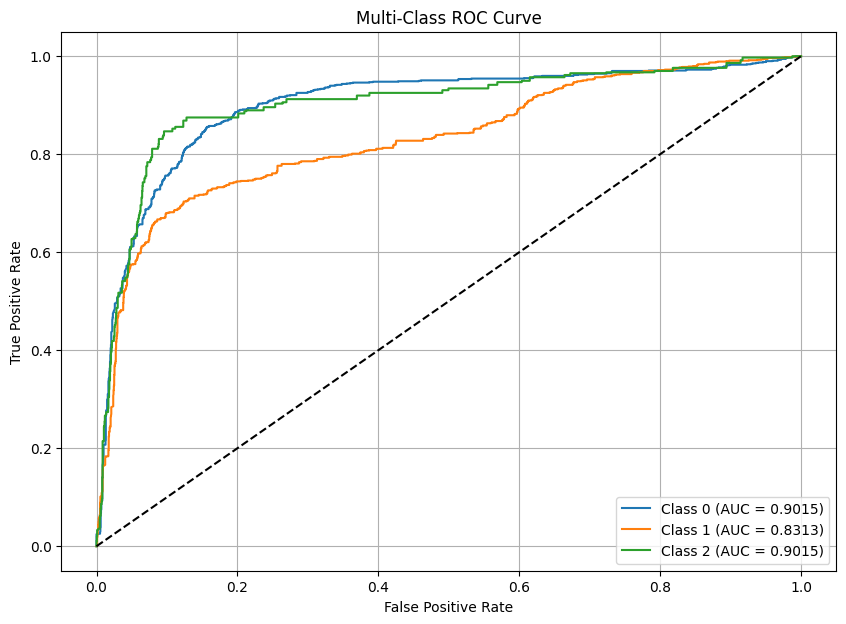

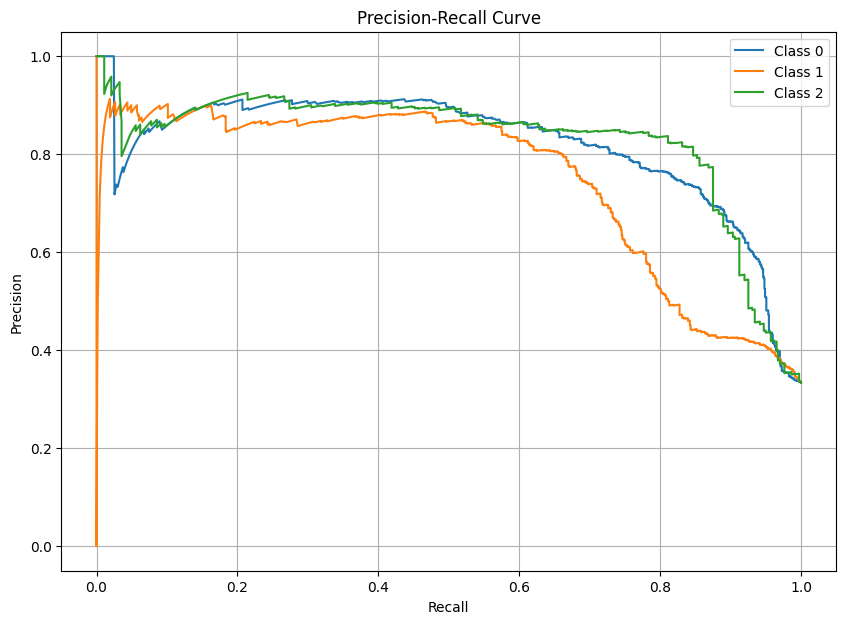

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
import numpy as np

# **Step 1: Convert True Labels to One-Hot Encoding (Required for Multi-Class)**
num_classes = len(set(true_labels))  # Number of classes
true_labels_one_hot = label_binarize(true_labels, classes=np.arange(num_classes))

# **Step 2: Get Softmax Probabilities for ROC & PR Curves**
model.eval()
all_probs = []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["label"].to(device)
        outputs = model(input_ids, attention_mask)
        probs = torch.exp(outputs).cpu().numpy()  # Convert log-softmax to probabilities
        all_probs.extend(probs)

all_probs = np.array(all_probs)

# **Step 3: Plot ROC Curves for Each Class**
plt.figure(figsize=(10, 7))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(true_labels_one_hot[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.4f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curve")
plt.legend()
plt.grid()
plt.show()

# **Step 4: Plot Precision-Recall Curves for Each Class**
plt.figure(figsize=(10, 7))
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(true_labels_one_hot[:, i], all_probs[:, i])
    plt.plot(recall, precision, label=f"Class {i}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import re
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report
from nltk.corpus import stopwords
import nltk

# Download stopwords if not available
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Load BanglaBERT Tokenizer
tokenizer = AutoTokenizer.from_pretrained("csebuetnlp/banglabert")

# Load Dataset
def load_data(file_path):
    df = pd.read_csv(file_path)
    df = df[['text', 'label']]
    return df

train_df = load_data("/kaggle/input/violencetext/train.csv")
dev_df = load_data("/kaggle/input/violencetext/dev.csv")
test_df = load_data("/kaggle/input/violencetext/test.csv")

# Text Preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\S+@\S+', '[EMAIL]', text)  # Replace emails
    text = re.sub(r'http\S+|www\S+', '[URL]', text)  # Replace URLs
    text = re.sub(r'\d+', '[NUMBER]', text)  # Replace numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    text = re.sub(r'\s+', ' ', text).strip()  # Normalize whitespace
    return text

train_df["text"] = train_df["text"].apply(preprocess_text)
dev_df["text"] = dev_df["text"].apply(preprocess_text)
test_df["text"] = test_df["text"].apply(preprocess_text)

# Dataset Class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=70):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

# Prepare datasets
train_dataset = TextDataset(train_df["text"].tolist(), train_df["label"].tolist(), tokenizer)
dev_dataset = TextDataset(dev_df["text"].tolist(), dev_df["label"].tolist(), tokenizer)
test_dataset = TextDataset(test_df["text"].tolist(), test_df["label"].tolist(), tokenizer)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Capsule Network Layer
class CapsuleLayer(nn.Module):
    def __init__(self, num_capsules, input_dim, output_dim, routing_iterations=1):
        super(CapsuleLayer, self).__init__()
        self.num_capsules = num_capsules
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.routing_iterations = routing_iterations
        self.weights = nn.Parameter(torch.randn(num_capsules, input_dim, output_dim))

    def forward(self, x):
        x = x.unsqueeze(1).expand(-1, self.num_capsules, -1, -1)
        u_hat = torch.matmul(x, self.weights)

        b_ij = torch.zeros(u_hat.shape[0], self.num_capsules, u_hat.shape[2]).to(x.device)

        for _ in range(self.routing_iterations):
            c_ij = torch.nn.functional.softmax(b_ij, dim=1)
            s_j = (c_ij.unsqueeze(-1) * u_hat).sum(dim=2)
            v_j = self.squash(s_j)
            b_ij = b_ij + (u_hat * v_j.unsqueeze(2)).sum(dim=-1)

        return v_j

    @staticmethod
    def squash(tensor):
        norm = (tensor ** 2).sum(dim=-1, keepdim=True)
        scale = norm / (1 + norm)
        return scale * tensor / torch.sqrt(norm + 1e-8)

# Define CAPTAIN Model using BanglaBERT
class CAPTAINModel(nn.Module):
    def __init__(self, num_classes=3):
        super(CAPTAINModel, self).__init__()
        self.bert = AutoModel.from_pretrained("csebuetnlp/banglabert")
        self.capsule = CapsuleLayer(num_capsules=8, input_dim=768, output_dim=16)
        self.flatten = nn.Flatten()
        self.batch_norm = nn.BatchNorm1d(128)  # Batch Normalization
        self.fc1 = nn.Linear(8 * 16, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.2)

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        caps_output = self.capsule(bert_output)
        flat_output = self.flatten(caps_output)
        x = self.batch_norm(torch.relu(self.fc1(flat_output)))
        x = self.dropout(x)
        logits = self.fc2(x)
        return logits

# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CAPTAINModel().to(device)

# Compute Class Weights
class_counts = train_df['label'].value_counts().tolist()
class_weights = torch.tensor(1.0 / np.array(class_counts), dtype=torch.float).to(device)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-5)  # Lower Learning Rate
criterion = nn.CrossEntropyLoss(weight=class_weights)  # Weighted Loss

# Training Loop with Progress Bar & Training Accuracy
epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct, total = 0, 0  # Track training accuracy

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

    for batch in progress_bar:
        input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate Training Accuracy
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        train_acc = correct / total

        progress_bar.set_postfix(loss=total_loss / (total + 1), accuracy=f"{train_acc:.4f}")

    print(f"Epoch {epoch+1} Loss: {total_loss:.4f}, Training Accuracy: {train_acc:.4f}")

# Evaluation
model.eval()
predictions, true_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["label"].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        labels = labels.cpu().numpy()

        predictions.extend(preds)
        true_labels.extend(labels)

# Classification Report
print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=["NV", "PV", "DV"]))


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Epoch 1 Loss: 90.5630, Training Accuracy: 0.4111


Epoch 2 Loss: 75.6795, Training Accuracy: 0.5252


Epoch 3 Loss: 67.7096, Training Accuracy: 0.5922


Epoch 4 Loss: 60.3145, Training Accuracy: 0.6478


Epoch 5 Loss: 52.2500, Training Accuracy: 0.7178
Classification Report:
              precision    recall  f1-score   support

          NV       0.76      0.62      0.68      1096
          PV       0.70      0.37      0.48       719
          DV       0.22      0.83      0.35       201

    accuracy                           0.55      2016
   macro avg       0.56      0.61      0.50      2016
weighted avg       0.68      0.55      0.58      2016



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import re
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report
from nltk.corpus import stopwords
import nltk

# Download stopwords if not available
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Load BanglaBERT Tokenizer
tokenizer = AutoTokenizer.from_pretrained("csebuetnlp/banglabert")

# Load Dataset
def load_data(file_path):
    df = pd.read_csv(file_path)
    df = df[['text', 'label']]
    return df

train_df = load_data("/kaggle/input/violencetext/train.csv")
dev_df = load_data("/kaggle/input/violencetext/dev.csv")
test_df = load_data("/kaggle/input/violencetext/test.csv")

# Text Preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\S+@\S+', '[EMAIL]', text)  # Replace emails
    text = re.sub(r'http\S+|www\S+', '[URL]', text)  # Replace URLs
    text = re.sub(r'\d+', '[NUMBER]', text)  # Replace numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    text = re.sub(r'\s+', ' ', text).strip()  # Normalize whitespace
    return text

train_df["text"] = train_df["text"].apply(preprocess_text)
dev_df["text"] = dev_df["text"].apply(preprocess_text)
test_df["text"] = test_df["text"].apply(preprocess_text)

# Dataset Class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=70):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

# Prepare datasets
train_dataset = TextDataset(train_df["text"].tolist(), train_df["label"].tolist(), tokenizer)
dev_dataset = TextDataset(dev_df["text"].tolist(), dev_df["label"].tolist(), tokenizer)
test_dataset = TextDataset(test_df["text"].tolist(), test_df["label"].tolist(), tokenizer)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Capsule Network Layer
class CapsuleLayer(nn.Module):
    def __init__(self, num_capsules, input_dim, output_dim, routing_iterations=1):
        super(CapsuleLayer, self).__init__()
        self.num_capsules = num_capsules
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.routing_iterations = routing_iterations
        self.weights = nn.Parameter(torch.randn(num_capsules, input_dim, output_dim))

    def forward(self, x):
        x = x.unsqueeze(1).expand(-1, self.num_capsules, -1, -1)
        u_hat = torch.matmul(x, self.weights)

        b_ij = torch.zeros(u_hat.shape[0], self.num_capsules, u_hat.shape[2]).to(x.device)

        for _ in range(self.routing_iterations):
            c_ij = torch.nn.functional.softmax(b_ij, dim=1)
            s_j = (c_ij.unsqueeze(-1) * u_hat).sum(dim=2)
            v_j = self.squash(s_j)
            b_ij = b_ij + (u_hat * v_j.unsqueeze(2)).sum(dim=-1)

        return v_j

    @staticmethod
    def squash(tensor):
        norm = (tensor ** 2).sum(dim=-1, keepdim=True)
        scale = norm / (1 + norm)
        return scale * tensor / torch.sqrt(norm + 1e-8)

# Define CAPTAIN Model using BanglaBERT
class CAPTAINModel(nn.Module):
    def __init__(self, num_classes=3):
        super(CAPTAINModel, self).__init__()
        self.bert = AutoModel.from_pretrained("csebuetnlp/banglabert")
        self.capsule = CapsuleLayer(num_capsules=8, input_dim=768, output_dim=16)
        self.flatten = nn.Flatten()
        self.batch_norm = nn.BatchNorm1d(128)  # Batch Normalization
        self.fc1 = nn.Linear(8 * 16, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.2)

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        caps_output = self.capsule(bert_output)
        flat_output = self.flatten(caps_output)
        x = self.batch_norm(torch.relu(self.fc1(flat_output)))
        x = self.dropout(x)
        logits = self.fc2(x)
        return logits

# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CAPTAINModel().to(device)

# Compute Class Weights
class_counts = train_df['label'].value_counts().tolist()
class_weights = torch.tensor(1.0 / np.array(class_counts), dtype=torch.float).to(device)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-5)  # Lower Learning Rate
criterion = nn.CrossEntropyLoss(weight=class_weights)  # Weighted Loss

# Training Loop with Progress Bar & Training Accuracy
epochs = 65
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct, total = 0, 0  # Track training accuracy

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

    for batch in progress_bar:
        input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate Training Accuracy
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        train_acc = correct / total

        progress_bar.set_postfix(loss=total_loss / (total + 1), accuracy=f"{train_acc:.4f}")

    print(f"Epoch {epoch+1} Loss: {total_loss:.4f}, Training Accuracy: {train_acc:.4f}")

# Evaluation
model.eval()
predictions, true_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["label"].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        labels = labels.cpu().numpy()

        predictions.extend(preds)
        true_labels.extend(labels)

# Classification Report with 4 Decimal Precision
print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=["NV", "PV", "DV"], digits=4))



[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Epoch 1 Loss: 47.1379, Training Accuracy: 0.3333


Epoch 2 Loss: 39.8336, Training Accuracy: 0.4541


Epoch 3 Loss: 35.8917, Training Accuracy: 0.5378


Epoch 4 Loss: 32.2777, Training Accuracy: 0.6030


Epoch 5 Loss: 29.2260, Training Accuracy: 0.6522


Epoch 6 Loss: 26.2702, Training Accuracy: 0.6996


Epoch 7 Loss: 23.1622, Training Accuracy: 0.7544


Epoch 8 Loss: 19.9075, Training Accuracy: 0.7885


Epoch 9 Loss: 16.9193, Training Accuracy: 0.8281


Epoch 10 Loss: 14.9766, Training Accuracy: 0.8637


Epoch 11 Loss: 12.8331, Training Accuracy: 0.8904


Epoch 12 Loss: 10.8775, Training Accuracy: 0.9133


Epoch 13 Loss: 9.2976, Training Accuracy: 0.9252


Epoch 14 Loss: 7.9698, Training Accuracy: 0.9448


Epoch 15 Loss: 6.2536, Training Accuracy: 0.9593


Epoch 16 Loss: 5.2451, Training Accuracy: 0.9693


Epoch 17 Loss: 5.4974, Training Accuracy: 0.9644


Epoch 18 Loss: 3.7905, Training Accuracy: 0.9807


Epoch 19 Loss: 3.5372, Training Accuracy: 0.9796


Epoch 20 Loss: 3.6097, Training Accuracy: 0.9844


Epoch 21 Loss: 3.5624, Training Accuracy: 0.9778


Epoch 22 Loss: 3.2361, Training Accuracy: 0.9867


Epoch 23 Loss: 3.0609, Training Accuracy: 0.9819


Epoch 24 Loss: 3.1328, Training Accuracy: 0.9837


Epoch 25 Loss: 3.0074, Training Accuracy: 0.9863


Epoch 26 Loss: 2.8378, Training Accuracy: 0.9826


Epoch 27 Loss: 2.1746, Training Accuracy: 0.9904


Epoch 28 Loss: 1.9719, Training Accuracy: 0.9911


Epoch 29 Loss: 1.8771, Training Accuracy: 0.9930


Epoch 30 Loss: 2.5186, Training Accuracy: 0.9867


Epoch 31 Loss: 1.8369, Training Accuracy: 0.9919


Epoch 32 Loss: 1.8938, Training Accuracy: 0.9907


Epoch 33 Loss: 1.6088, Training Accuracy: 0.9937


Epoch 34 Loss: 2.8451, Training Accuracy: 0.9778


Epoch 35 Loss: 1.5213, Training Accuracy: 0.9930


Epoch 36 Loss: 2.0841, Training Accuracy: 0.9941


Epoch 37 Loss: 2.7549, Training Accuracy: 0.9830


Epoch 38 Loss: 2.5308, Training Accuracy: 0.9874


Epoch 39 Loss: 1.6720, Training Accuracy: 0.9930


Epoch 40 Loss: 1.1722, Training Accuracy: 0.9981


Epoch 41 Loss: 1.1464, Training Accuracy: 0.9959


Epoch 42 Loss: 1.1027, Training Accuracy: 0.9956


Epoch 43 Loss: 1.1651, Training Accuracy: 0.9959


Epoch 44 Loss: 1.1250, Training Accuracy: 0.9963


Epoch 45 Loss: 0.9951, Training Accuracy: 0.9974


Epoch 46 Loss: 0.9406, Training Accuracy: 0.9963


Epoch 47 Loss: 0.7957, Training Accuracy: 0.9989


Epoch 48 Loss: 0.8024, Training Accuracy: 0.9974


Epoch 49 Loss: 1.2946, Training Accuracy: 0.9937


Epoch 50 Loss: 2.0653, Training Accuracy: 0.9889


Epoch 51 Loss: 1.3919, Training Accuracy: 0.9926


Epoch 52 Loss: 2.1776, Training Accuracy: 0.9852


Epoch 53 Loss: 1.2676, Training Accuracy: 0.9937


Epoch 54 Loss: 0.8502, Training Accuracy: 0.9978


Epoch 55 Loss: 0.7580, Training Accuracy: 0.9993


Epoch 56 Loss: 0.7410, Training Accuracy: 0.9985


Epoch 57 Loss: 0.6629, Training Accuracy: 0.9985


Epoch 58 Loss: 0.5590, Training Accuracy: 0.9996


Epoch 59 Loss: 0.8904, Training Accuracy: 0.9948


Epoch 60 Loss: 0.8047, Training Accuracy: 0.9963


Epoch 61 Loss: 1.0113, Training Accuracy: 0.9959


Epoch 62 Loss: 0.7224, Training Accuracy: 0.9981


Epoch 63 Loss: 0.9705, Training Accuracy: 0.9948


Epoch 64 Loss: 0.5617, Training Accuracy: 0.9989


Epoch 65 Loss: 0.7398, Training Accuracy: 0.9963
Classification Report:
              precision    recall  f1-score   support

          NV     0.6949    0.8750    0.7746      1096
          PV     0.7658    0.3866    0.5139       719
          DV     0.4982    0.6766    0.5738       201

    accuracy                         0.6811      2016
   macro avg     0.6530    0.6461    0.6208      2016
weighted avg     0.7006    0.6811    0.6616      2016



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import re
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report
from nltk.corpus import stopwords
import nltk

# Download stopwords if not available
nltk.download('stopwords')
stop_words = set(stopwords.words('bengali'))

# Load BanglaBERT Tokenizer
tokenizer = AutoTokenizer.from_pretrained("csebuetnlp/banglabert")

# Load Dataset
def load_data(file_path):
    df = pd.read_csv(file_path)
    df = df[['text', 'label']]
    return df

train_df = load_data("/kaggle/input/violencetext/train.csv")
dev_df = load_data("/kaggle/input/violencetext/dev.csv")
test_df = load_data("/kaggle/input/violencetext/test.csv")

# Text Preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\S+@\S+', '[EMAIL]', text)  # Replace emails
    text = re.sub(r'http\S+|www\S+', '[URL]', text)  # Replace URLs
    text = re.sub(r'\d+', '[NUMBER]', text)  # Replace numbers
    text = re.sub(r'[^\u0980-\u09FF\s]', '', text)  # Remove non-Bangla characters
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    text = re.sub(r'\s+', ' ', text).strip()  # Normalize whitespace
    return text

train_df["text"] = train_df["text"].apply(preprocess_text)
dev_df["text"] = dev_df["text"].apply(preprocess_text)
test_df["text"] = test_df["text"].apply(preprocess_text)

# Dataset Class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=70):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

# Prepare datasets
train_dataset = TextDataset(train_df["text"].tolist(), train_df["label"].tolist(), tokenizer)
dev_dataset = TextDataset(dev_df["text"].tolist(), dev_df["label"].tolist(), tokenizer)
test_dataset = TextDataset(test_df["text"].tolist(), test_df["label"].tolist(), tokenizer)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Capsule Network Layer
class CapsuleLayer(nn.Module):
    def __init__(self, num_capsules, input_dim, output_dim, routing_iterations=1):
        super(CapsuleLayer, self).__init__()
        self.num_capsules = num_capsules
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.routing_iterations = routing_iterations
        self.weights = nn.Parameter(torch.randn(num_capsules, input_dim, output_dim))

    def forward(self, x):
        x = x.unsqueeze(1).expand(-1, self.num_capsules, -1, -1)
        u_hat = torch.matmul(x, self.weights)

        b_ij = torch.zeros(u_hat.shape[0], self.num_capsules, u_hat.shape[2]).to(x.device)

        for _ in range(self.routing_iterations):
            c_ij = torch.nn.functional.softmax(b_ij, dim=1)
            s_j = (c_ij.unsqueeze(-1) * u_hat).sum(dim=2)
            v_j = self.squash(s_j)
            b_ij = b_ij + (u_hat * v_j.unsqueeze(2)).sum(dim=-1)

        return v_j

    @staticmethod
    def squash(tensor):
        norm = (tensor ** 2).sum(dim=-1, keepdim=True)
        scale = norm / (1 + norm)
        return scale * tensor / torch.sqrt(norm + 1e-8)

# Define CAPTAIN Model using BanglaBERT
class CAPTAINModel(nn.Module):
    def __init__(self, num_classes=3):
        super(CAPTAINModel, self).__init__()
        self.bert = AutoModel.from_pretrained("csebuetnlp/banglabert")
        self.capsule = CapsuleLayer(num_capsules=8, input_dim=768, output_dim=16)
        self.flatten = nn.Flatten()
        self.batch_norm = nn.BatchNorm1d(128)  # Batch Normalization
        self.fc1 = nn.Linear(8 * 16, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.2)

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        caps_output = self.capsule(bert_output)
        flat_output = self.flatten(caps_output)
        x = self.batch_norm(torch.relu(self.fc1(flat_output)))
        x = self.dropout(x)
        logits = self.fc2(x)
        return logits

# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CAPTAINModel().to(device)

# Compute Class Weights
class_counts = train_df['label'].value_counts().tolist()
class_weights = torch.tensor(1.0 / np.array(class_counts), dtype=torch.float).to(device)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-5)  # Lower Learning Rate
criterion = nn.CrossEntropyLoss(weight=class_weights)  # Weighted Loss

# Training Loop with Progress Bar & Training Accuracy
epochs = 30
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct, total = 0, 0  # Track training accuracy

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

    for batch in progress_bar:
        input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate Training Accuracy
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        train_acc = correct / total

        progress_bar.set_postfix(loss=total_loss / (total + 1), accuracy=f"{train_acc:.4f}")

    print(f"Epoch {epoch+1} Loss: {total_loss:.4f}, Training Accuracy: {train_acc:.4f}")

# Evaluation
model.eval()
predictions, true_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["label"].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        labels = labels.cpu().numpy()

        predictions.extend(preds)
        true_labels.extend(labels)

# Classification Report
print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=["NV", "PV", "DV"]))


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Epoch 1 Loss: 46.1069, Training Accuracy: 0.4615


Epoch 2 Loss: 36.2886, Training Accuracy: 0.6341


Epoch 3 Loss: 30.5284, Training Accuracy: 0.6919


Epoch 4 Loss: 25.7893, Training Accuracy: 0.7370


Epoch 5 Loss: 21.8683, Training Accuracy: 0.7896


Epoch 6 Loss: 18.8457, Training Accuracy: 0.8219


Epoch 7 Loss: 16.4383, Training Accuracy: 0.8578


Epoch 8 Loss: 13.1244, Training Accuracy: 0.8856


Epoch 9 Loss: 10.6597, Training Accuracy: 0.9233


Epoch 10 Loss: 8.9649, Training Accuracy: 0.9381


Epoch 11 Loss: 7.0917, Training Accuracy: 0.9596


Epoch 12 Loss: 5.9511, Training Accuracy: 0.9656


Epoch 13 Loss: 4.7017, Training Accuracy: 0.9781


Epoch 14 Loss: 3.9404, Training Accuracy: 0.9844


Epoch 15 Loss: 3.9233, Training Accuracy: 0.9796


Epoch 16 Loss: 3.1007, Training Accuracy: 0.9904


Epoch 17 Loss: 2.4924, Training Accuracy: 0.9944


Epoch 18 Loss: 2.3394, Training Accuracy: 0.9904


Epoch 19 Loss: 1.9641, Training Accuracy: 0.9967


Epoch 20 Loss: 1.9422, Training Accuracy: 0.9933


Epoch 21 Loss: 1.8140, Training Accuracy: 0.9944


Epoch 22 Loss: 1.6834, Training Accuracy: 0.9959


Epoch 23 Loss: 1.5579, Training Accuracy: 0.9944


Epoch 24 Loss: 1.3695, Training Accuracy: 0.9974


Epoch 25 Loss: 1.3386, Training Accuracy: 0.9952


Epoch 26 Loss: 1.4898, Training Accuracy: 0.9941


Epoch 27 Loss: 1.1281, Training Accuracy: 0.9948


Epoch 28 Loss: 1.1536, Training Accuracy: 0.9970


Epoch 29 Loss: 0.9582, Training Accuracy: 0.9967


Epoch 30 Loss: 1.0434, Training Accuracy: 0.9967
Classification Report:
              precision    recall  f1-score   support

          NV       0.81      0.81      0.81      1096
          PV       0.74      0.60      0.66       719
          DV       0.42      0.69      0.52       201

    accuracy                           0.72      2016
   macro avg       0.65      0.70      0.66      2016
weighted avg       0.74      0.72      0.73      2016



# With BanglaBERT

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import re
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
from sklearn.metrics import classification_report
from nltk.corpus import stopwords
import nltk
from imblearn.over_sampling import RandomOverSampler

# Download stopwords if not available
nltk.download('stopwords')
stop_words = set(stopwords.words('bengali'))

# Load BanglaBERT Tokenizer
tokenizer = AutoTokenizer.from_pretrained("csebuetnlp/banglabert")

# Load Dataset
def load_data(file_path):
    df = pd.read_csv(file_path)
    df = df[['text', 'label']]
    return df

train_df = load_data("/kaggle/input/violencetext/train.csv")
dev_df = load_data("/kaggle/input/violencetext/dev.csv")
test_df = load_data("/kaggle/input/violencetext/test.csv")

# Text Preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\S+@\S+', '[EMAIL]', text)  # Replace emails
    text = re.sub(r'http\S+|www\S+', '[URL]', text)  # Replace URLs
    text = re.sub(r'\d+', '[NUMBER]', text)  # Replace numbers
    text = re.sub(r'[^\u0980-\u09FF\s]', '', text)  # Remove non-Bangla characters
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    text = re.sub(r'\s+', ' ', text).strip()  # Normalize whitespace
    return text

train_df["text"] = train_df["text"].apply(preprocess_text)
dev_df["text"] = dev_df["text"].apply(preprocess_text)
test_df["text"] = test_df["text"].apply(preprocess_text)

# Oversampling using RandomOverSampler
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = ros.fit_resample(train_df[['text']], train_df['label'])
train_df = pd.DataFrame({'text': X_resampled['text'], 'label': y_resampled})

# Dataset Class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=70):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

# Prepare datasets
train_dataset = TextDataset(train_df["text"].tolist(), train_df["label"].tolist(), tokenizer)
dev_dataset = TextDataset(dev_df["text"].tolist(), dev_df["label"].tolist(), tokenizer)
test_dataset = TextDataset(test_df["text"].tolist(), test_df["label"].tolist(), tokenizer)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model (Same as before)
class CAPTAINModel(nn.Module):
    def __init__(self, num_classes=3):
        super(CAPTAINModel, self).__init__()
        self.bert = AutoModel.from_pretrained("csebuetnlp/banglabert")
        self.fc1 = nn.Linear(768, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        pooled_output = bert_output[:, 0, :]  # Use CLS token embedding as pooled output
        x = self.dropout(torch.relu(self.fc1(pooled_output)))
        logits = self.fc2(x)
        return logits



# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CAPTAINModel().to(device)

# Compute Class Weights
class_counts = train_df['label'].value_counts().tolist()
class_weights = torch.tensor(1.0 / np.array(class_counts), dtype=torch.float).to(device)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Training Loop with Oversampled Data
epochs = 30
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct, total = 0, 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

    for batch in progress_bar:
        input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        train_acc = correct / total

        progress_bar.set_postfix(loss=total_loss / (total + 1), accuracy=f"{train_acc:.4f}")

    print(f"Epoch {epoch+1} Loss: {total_loss:.4f}, Training Accuracy: {train_acc:.4f}")

# Evaluation
model.eval()
predictions, true_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["label"].to(device)
        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        labels = labels.cpu().numpy()
        predictions.extend(preds)
        true_labels.extend(labels)

# Classification Report
print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=["NV", "PV", "DV"]))


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Epoch 1 Loss: 69.2153, Training Accuracy: 0.4944


Epoch 2 Loss: 48.1336, Training Accuracy: 0.7490


Epoch 3 Loss: 31.5231, Training Accuracy: 0.8426


Epoch 4 Loss: 21.4057, Training Accuracy: 0.9057


Epoch 5 Loss: 15.8744, Training Accuracy: 0.9369


Epoch 6 Loss: 12.3001, Training Accuracy: 0.9496


Epoch 7 Loss: 8.9126, Training Accuracy: 0.9705


Epoch 8 Loss: 7.3141, Training Accuracy: 0.9760


Epoch 9 Loss: 6.2424, Training Accuracy: 0.9803


Epoch 10 Loss: 5.9735, Training Accuracy: 0.9808


Epoch 11 Loss: 4.9414, Training Accuracy: 0.9830


Epoch 12 Loss: 4.3846, Training Accuracy: 0.9863


Epoch 13 Loss: 3.6360, Training Accuracy: 0.9894


Epoch 14 Loss: 3.5600, Training Accuracy: 0.9897


Epoch 15 Loss: 2.8327, Training Accuracy: 0.9918


Epoch 16 Loss: 2.6088, Training Accuracy: 0.9923


Epoch 17 Loss: 2.5436, Training Accuracy: 0.9928


Epoch 18 Loss: 2.3491, Training Accuracy: 0.9933


Epoch 19 Loss: 2.0390, Training Accuracy: 0.9938


Epoch 20 Loss: 2.0511, Training Accuracy: 0.9940


Epoch 21 Loss: 2.1087, Training Accuracy: 0.9928


Epoch 22 Loss: 2.0187, Training Accuracy: 0.9928


Epoch 23 Loss: 1.6108, Training Accuracy: 0.9942


Epoch 24 Loss: 1.5553, Training Accuracy: 0.9940


Epoch 25 Loss: 1.6033, Training Accuracy: 0.9938


Epoch 26 Loss: 1.2297, Training Accuracy: 0.9952


Epoch 27 Loss: 1.4386, Training Accuracy: 0.9938


Epoch 28 Loss: 1.4671, Training Accuracy: 0.9940


Epoch 29 Loss: 2.0288, Training Accuracy: 0.9904


Epoch 30 Loss: 1.0301, Training Accuracy: 0.9966
Classification Report:
              precision    recall  f1-score   support

          NV       0.78      0.86      0.81      1096
          PV       0.76      0.61      0.68       719
          DV       0.50      0.54      0.52       201

    accuracy                           0.74      2016
   macro avg       0.68      0.67      0.67      2016
weighted avg       0.74      0.74      0.74      2016



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import re
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
from sklearn.metrics import classification_report
from nltk.corpus import stopwords
import nltk
from imblearn.over_sampling import RandomOverSampler

# Download stopwords if not available
nltk.download('stopwords')
stop_words = set(stopwords.words('bengali'))

# Load BanglaBERT Tokenizer
tokenizer = AutoTokenizer.from_pretrained("csebuetnlp/banglabert")

# Load Dataset
def load_data(file_path):
    df = pd.read_csv(file_path)
    df = df[['text', 'label']]
    return df

train_df = load_data("/kaggle/input/violencetext/train.csv")
dev_df = load_data("/kaggle/input/violencetext/dev.csv")
test_df = load_data("/kaggle/input/violencetext/test.csv")

# Text Preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\S+@\S+', '[EMAIL]', text)  # Replace emails
    text = re.sub(r'http\S+|www\S+', '[URL]', text)  # Replace URLs
    text = re.sub(r'\d+', '[NUMBER]', text)  # Replace numbers
    text = re.sub(r'[^\u0980-\u09FF\s]', '', text)  # Remove non-Bangla characters
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    text = re.sub(r'\s+', ' ', text).strip()  # Normalize whitespace
    return text

train_df["text"] = train_df["text"].apply(preprocess_text)
dev_df["text"] = dev_df["text"].apply(preprocess_text)
test_df["text"] = test_df["text"].apply(preprocess_text)

# Oversampling using RandomOverSampler for all datasets
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)

train_df, train_labels = ros.fit_resample(train_df[['text']], train_df['label'])
dev_df, dev_labels = ros.fit_resample(dev_df[['text']], dev_df['label'])
test_df, test_labels = ros.fit_resample(test_df[['text']], test_df['label'])

# Convert back to DataFrame
train_df = pd.DataFrame({'text': train_df['text'], 'label': train_labels})
dev_df = pd.DataFrame({'text': dev_df['text'], 'label': dev_labels})
test_df = pd.DataFrame({'text': test_df['text'], 'label': test_labels})

# Dataset Class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=100):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

# Prepare datasets
train_dataset = TextDataset(train_df["text"].tolist(), train_df["label"].tolist(), tokenizer)
dev_dataset = TextDataset(dev_df["text"].tolist(), dev_df["label"].tolist(), tokenizer)
test_dataset = TextDataset(test_df["text"].tolist(), test_df["label"].tolist(), tokenizer)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Enhanced Model Class
class EnhancedBanglaBERT(nn.Module):
    def __init__(self, num_classes=3):
        super(EnhancedBanglaBERT, self).__init__()
        self.bert = AutoModel.from_pretrained("csebuetnlp/banglabert")
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.4)

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        pooled_output = bert_output[:, 0, :]  # Use CLS token embedding
        x = self.dropout(torch.relu(self.fc1(pooled_output)))
        x = self.dropout(torch.relu(self.fc2(x)))
        logits = self.fc3(x)
        return logits

# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EnhancedBanglaBERT().to(device)

# Compute Class Weights
class_counts = train_df['label'].value_counts().tolist()
class_weights = torch.tensor(1.0 / np.array(class_counts), dtype=torch.float).to(device)

# Define optimizer, loss function, and scheduler
optimizer = optim.AdamW(model.parameters(), lr=3e-5, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(weight=class_weights)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Training Loop with Oversampling
epochs = 40
for epoch in range(epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
    for batch in progress_bar:
        input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["label"].to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    scheduler.step()
    print(f"Epoch {epoch+1} Loss: {total_loss:.4f}, Training Accuracy: {correct/total:.4f}")

# Evaluation
model.eval()
predictions, true_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["label"].to(device)
        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        labels = labels.cpu().numpy()
        predictions.extend(preds)
        true_labels.extend(labels)

print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=["NV", "PV", "DV"], digits=4))



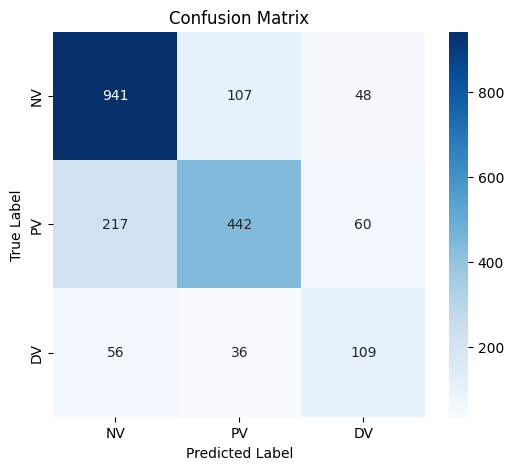

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Define Class Labels
class_labels = ["NV", "PV", "DV"]

# Plot the Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


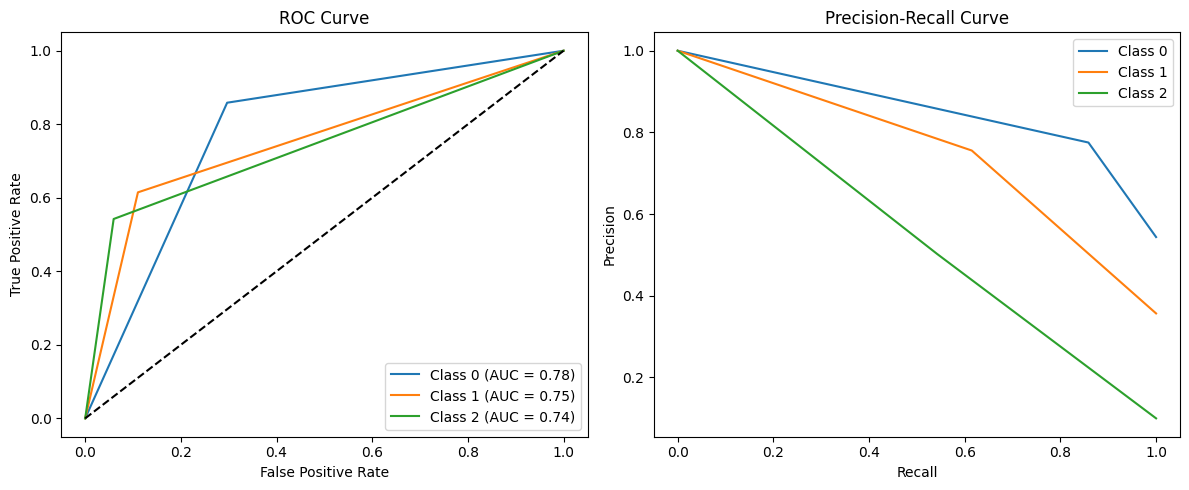

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Convert labels to one-hot encoding
from sklearn.preprocessing import label_binarize

num_classes = len(set(true_labels))  # Get the number of classes
true_labels_one_hot = label_binarize(true_labels, classes=[0, 1, 2])  # Adjust class labels based on dataset
predictions_one_hot = label_binarize(predictions, classes=[0, 1, 2])

# ROC Curve
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)  # First plot for ROC Curve
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(true_labels_one_hot[:, i], predictions_one_hot[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0,1], [0,1], 'k--')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

# Precision-Recall Curve
plt.subplot(1,2,2)  # Second plot for Precision-Recall Curve
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(true_labels_one_hot[:, i], predictions_one_hot[:, i])
    plt.plot(recall, precision, label=f'Class {i}')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()

plt.tight_layout()
plt.show()


# Modified _Violence

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import re
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import RandomOverSampler  # Import RandomOverSampler
import unicodedata

# Load BanglaBERT Tokenizer
tokenizer = AutoTokenizer.from_pretrained("csebuetnlp/banglabert")

# Load Dataset
def load_data(file_path):
    df = pd.read_csv(file_path)
    df = df[['text', 'Target']]
    return df

train_df = load_data("/kaggle/input/mofied2/train_modified.csv")
dev_df = load_data("/kaggle/input/mofied2/dev_modified.csv")
test_df = load_data("/kaggle/input/mofied2/test_modified.csv")


# Check unique values in the Target column
print("Unique labels in train dataset:", train_df["Target"].unique())
print("Unique labels in dev dataset:", dev_df["Target"].unique())
print("Unique labels in test dataset:", test_df["Target"].unique())

# **Step 1: Apply Random Oversampling to Balance the Datasets**
def oversample_dataset(df):
    ros = RandomOverSampler(random_state=42)
    texts, labels = df["text"].values, df["Target"].values
    texts_resampled, labels_resampled = ros.fit_resample(texts.reshape(-1, 1), labels)

    balanced_df = pd.DataFrame({"text": texts_resampled.flatten(), "Target": labels_resampled})
    return balanced_df

train_df = oversample_dataset(train_df)
dev_df = oversample_dataset(dev_df)
test_df = oversample_dataset(test_df)

# **Step 2: Preprocessing Function**
def preprocess_text(text):
    text = unicodedata.normalize('NFKC', text)  # Normalize Unicode text
    text = re.sub(r'[০-৯]', '[NUMBER]', text)  # Replace Bangla numbers
    text = re.sub(r'http\S+|www\S+', '[URL]', text)  # Replace URLs
    text = re.sub(r'[^\u0980-\u09FF\s]', '', text)  # Remove non-Bangla characters
    text = re.sub(r'\s+', ' ', text).strip()  # Normalize whitespace
    return text

train_df["text"] = train_df["text"].apply(preprocess_text)
dev_df["text"] = dev_df["text"].apply(preprocess_text)
test_df["text"] = test_df["text"].apply(preprocess_text)

# **Step 3: Define Dataset Class**
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=70):
        self.texts = texts
        self.labels = list(map(int, labels))  # Convert labels to integers
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]  # Ensure it's an integer

        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)  # Now correctly an integer
        }

# Define label mapping
label_mapping = {"TO": 0, "TC": 1, "TI": 2}

# Convert categorical labels to numerical labels
train_df["Target"] = train_df["Target"].map(label_mapping)
dev_df["Target"] = dev_df["Target"].map(label_mapping)
test_df["Target"] = test_df["Target"].map(label_mapping)

# Prepare datasets
train_dataset = TextDataset(train_df["text"].tolist(), train_df["Target"].tolist(), tokenizer)
dev_dataset = TextDataset(dev_df["text"].tolist(), dev_df["Target"].tolist(), tokenizer)
test_dataset = TextDataset(test_df["text"].tolist(), test_df["Target"].tolist(), tokenizer)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# **Step 4: Capsule Network Layer**
class CapsuleLayer(nn.Module):
    def __init__(self, num_capsules, input_dim, output_dim, routing_iterations=3):
        super(CapsuleLayer, self).__init__()
        self.num_capsules = num_capsules
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.routing_iterations = routing_iterations
        self.weights = nn.Parameter(torch.randn(num_capsules, input_dim, output_dim))

    def forward(self, x):
        x = x.unsqueeze(1).expand(-1, self.num_capsules, -1, -1)
        u_hat = torch.matmul(x, self.weights)

        b_ij = torch.zeros(u_hat.shape[0], self.num_capsules, u_hat.shape[2]).to(x.device)

        for _ in range(self.routing_iterations):
            c_ij = torch.nn.functional.softmax(b_ij, dim=1)
            s_j = (c_ij.unsqueeze(-1) * u_hat).sum(dim=2)
            v_j = self.squash(s_j)
            b_ij = b_ij + (u_hat * v_j.unsqueeze(2)).sum(dim=-1)

        return v_j

    @staticmethod
    def squash(tensor):
        norm = (tensor ** 2).sum(dim=-1, keepdim=True)
        scale = norm / (1 + norm)
        return scale * tensor / torch.sqrt(norm + 1e-8)

# **Step 5: Define CAPTAIN Model**
class CAPTAINModel(nn.Module):
    def __init__(self, num_classes=3):
        super(CAPTAINModel, self).__init__()
        self.bert = AutoModel.from_pretrained("csebuetnlp/banglabert")
        self.capsule = CapsuleLayer(num_capsules=8, input_dim=768, output_dim=16)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(8 * 16, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.batch_norm = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(0.5)

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        caps_output = self.capsule(bert_output)
        flat_output = self.flatten(caps_output)
        x = self.batch_norm(torch.relu(self.fc1(flat_output)))
        x = self.dropout(x)
        logits = self.fc2(x)
        return torch.nn.functional.log_softmax(logits, dim=1)

# **Step 6: Training Setup**
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CAPTAINModel().to(device)

optimizer = optim.AdamW(model.parameters(), lr=3e-5, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)

# **Step 7: Training Loop**
epochs = 40
for epoch in range(epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
        input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)

        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    scheduler.step()
    print(f"Epoch {epoch+1} Loss: {total_loss:.4f}, Accuracy: {correct/total:.4f}")

# **Step 8: Model Evaluation**
model.eval()
predictions, true_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["label"].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        labels = labels.cpu().numpy()

        predictions.extend(preds)
        true_labels.extend(labels)

# **Print Classification Report with 4-digit Precision**
print("Classification Report:")
print(classification_report(true_labels, predictions, digits=4))



Unique labels in train dataset: ['TO' 'TC' 'TI']
Unique labels in dev dataset: ['TO' 'TI' 'TC']
Unique labels in test dataset: ['TC' 'TI' 'TO']


Epoch 1 Loss: 137.3742, Accuracy: 0.3615


Epoch 2 Loss: 135.8928, Accuracy: 0.3671


Epoch 3 Loss: 128.2564, Accuracy: 0.4066


Epoch 4 Loss: 103.6621, Accuracy: 0.5618


Epoch 5 Loss: 73.7428, Accuracy: 0.7214


Epoch 6 Loss: 51.5773, Accuracy: 0.8243


Epoch 7 Loss: 37.1262, Accuracy: 0.8838


Epoch 8 Loss: 25.6427, Accuracy: 0.9292


Epoch 9 Loss: 17.2867, Accuracy: 0.9524


Epoch 10 Loss: 12.0133, Accuracy: 0.9718


Epoch 11 Loss: 7.8526, Accuracy: 0.9834


Epoch 12 Loss: 5.4010, Accuracy: 0.9895


Epoch 13 Loss: 5.4072, Accuracy: 0.9881


Epoch 14 Loss: 3.9906, Accuracy: 0.9923


Epoch 15 Loss: 3.9876, Accuracy: 0.9923


Epoch 16 Loss: 3.0102, Accuracy: 0.9947


Epoch 17 Loss: 2.1915, Accuracy: 0.9964


Epoch 18 Loss: 1.6246, Accuracy: 0.9975


Epoch 19 Loss: 2.1889, Accuracy: 0.9961


Epoch 20 Loss: 1.3973, Accuracy: 0.9975


Epoch 21 Loss: 1.5089, Accuracy: 0.9981


Epoch 22 Loss: 1.3412, Accuracy: 0.9981


Epoch 23 Loss: 1.3400, Accuracy: 0.9978


Epoch 24 Loss: 1.4415, Accuracy: 0.9972


Epoch 25 Loss: 1.1729, Accuracy: 0.9986


Epoch 26 Loss: 1.3257, Accuracy: 0.9978


Epoch 27 Loss: 0.9421, Accuracy: 0.9983


Epoch 28 Loss: 1.0580, Accuracy: 0.9986


Epoch 29 Loss: 0.8606, Accuracy: 0.9983


Epoch 30 Loss: 1.2510, Accuracy: 0.9981


Epoch 31 Loss: 1.0162, Accuracy: 0.9978


Epoch 32 Loss: 0.9940, Accuracy: 0.9983


Epoch 33 Loss: 0.9209, Accuracy: 0.9986


Epoch 34 Loss: 1.0261, Accuracy: 0.9983


Epoch 35 Loss: 1.0552, Accuracy: 0.9975


Epoch 36 Loss: 0.9158, Accuracy: 0.9983


Epoch 37 Loss: 1.0888, Accuracy: 0.9981


Epoch 38 Loss: 0.9807, Accuracy: 0.9981


Epoch 39 Loss: 0.7469, Accuracy: 0.9989


Epoch 40 Loss: 0.7708, Accuracy: 0.9994
Classification Report:
              precision    recall  f1-score   support

           0     0.8048    0.6226    0.7020      1073
           1     0.5634    0.8816    0.6875      1073
           2     0.8507    0.5629    0.6775      1073

    accuracy                         0.6890      3219
   macro avg     0.7397    0.6890    0.6890      3219
weighted avg     0.7397    0.6890    0.6890      3219



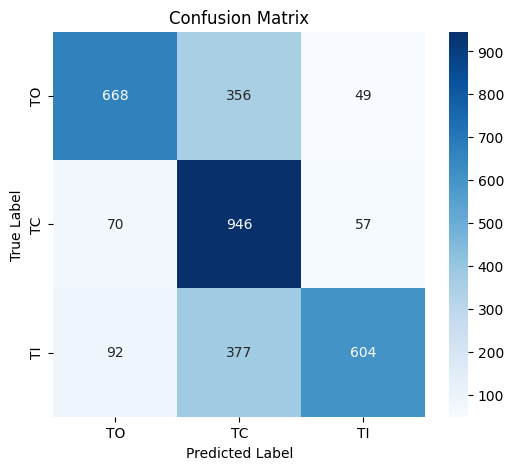

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Define class labels (Ensure this matches your dataset's label mapping)
class_labels = ["TO", "TC", "TI"]  # Replace with actual class names if different

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

# Labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


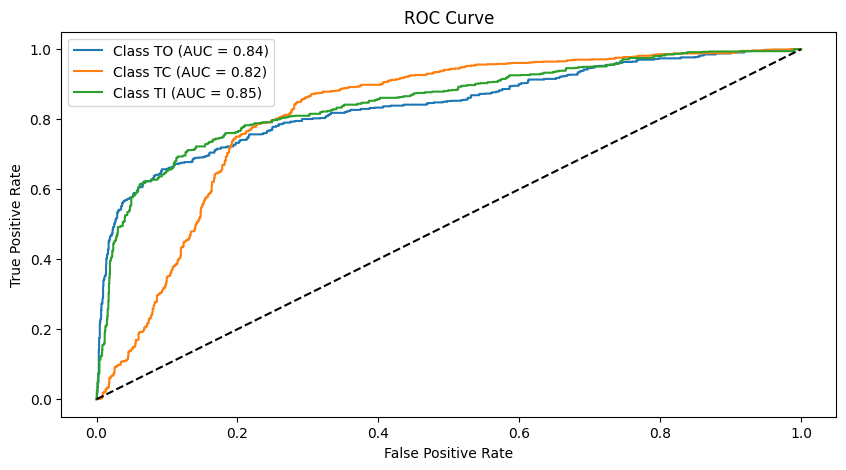

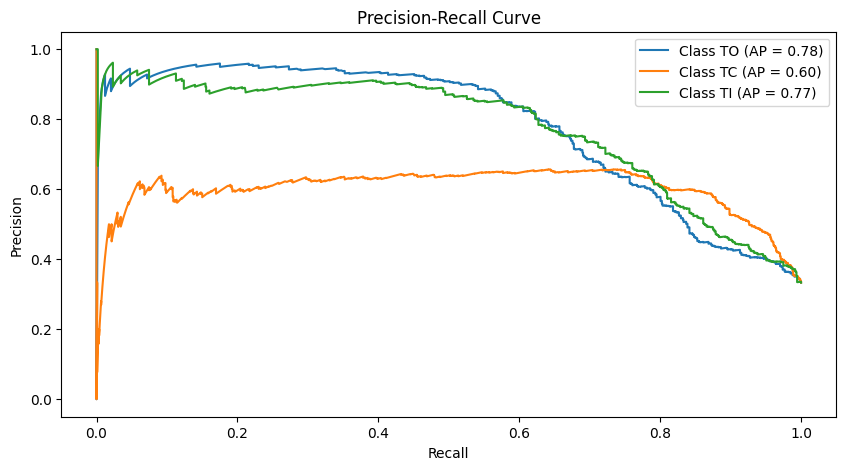

In [ ]:
# Model Evaluation
model.eval()
predictions, true_labels, all_probs = [], [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["label"].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        labels = labels.cpu().numpy()
        probs = torch.exp(outputs).cpu().numpy()  # Convert log-softmax to probabilities

        predictions.extend(preds)
        true_labels.extend(labels)
        all_probs.extend(probs)  # Collect all probability values

# Convert to numpy arrays
true_labels = np.array(true_labels)
predicted_probs = np.array(all_probs)  # Ensure probabilities are collected properly




from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Define class labels
class_labels = ["TO", "TC", "TI"]

# Plot ROC Curve for each class
plt.figure(figsize=(10, 5))

for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve((true_labels == i).astype(int), predicted_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {class_labels[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Plot Precision-Recall Curve
plt.figure(figsize=(10, 5))

for i in range(len(class_labels)):
    precision, recall, _ = precision_recall_curve((true_labels == i).astype(int), predicted_probs[:, i])
    avg_precision = average_precision_score((true_labels == i).astype(int), predicted_probs[:, i])
    plt.plot(recall, precision, label=f"Class {class_labels[i]} (AP = {avg_precision:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()
